## **Data Structure**:
```python
math_structure.from_text.domain          # Domain classification
math_structure.from_text.objects         # Problem objects
math_structure.from_text.constraints     # Problem constraints
math_structure.from_text.mechanisms      # Problem mechanisms
math_structure.from_solution.*           # Solution properties
computation_buckets[].level              # Difficulty buckets (minimum level with passed == 1)
```

## Setup & Load

In [2]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
%matplotlib inline

In [28]:
# Load JSONL data
DATA_PATH = '/home/larcanio/AIMO3_v2/data/datasets/Dataset_Full/bucketed/dataset_1_5_rerun_more_tokens.jsonl'

records = []
with open(DATA_PATH, 'r', encoding='utf-8') as f:
    for line in f:
        if line.strip():
            try:
                records.append(json.loads(line))
            except json.JSONDecodeError as e:
                print(f"Error parsing line: {e}")

print(f"Total records loaded: {len(records):,}")

Total records loaded: 71,832


## Extract Data Fields

In [29]:
# Extract relevant fields from math_structure
data = []
for record in records:
    row = {
        'id': record.get('id'),
        'dataset': record.get('dataset')
    }
    
    # Extract difficulty level from computation_buckets
    # The difficulty level is the minimum level where passes == 1
    if 'computation_buckets' in record and record['computation_buckets']:
        passed_levels = [bucket['level'] for bucket in record['computation_buckets'] 
                        if bucket.get('passes') == 1]
        if passed_levels:
            row['difficulty_level'] = min(passed_levels)

    # Extract outcome fields
    if 'outcome' in record and record['outcome']:
        row['pass_at_k'] = record['outcome'].get('pass_at_k')
    
    # Extract math_structure fields
    if 'math_structure' in record and record['math_structure']:
        ms = record['math_structure']
        
        # Extract from_text properties (including domain)
        if 'from_text' in ms and ms['from_text']:
            ft = ms['from_text']
            row['domain'] = ft.get('domain')  # Domain is in from_text.domain
            row['output_type'] = ft.get('output_type')
            row['mechanisms'] = ft.get('mechanisms', [])
            row['constraints'] = ft.get('constraints', [])
            row['objects'] = ft.get('objects', [])
            row['mechanisms_count'] = len(row['mechanisms']) if row['mechanisms'] else 0
            row['constraints_count'] = len(row['constraints']) if row['constraints'] else 0
            row['objects_count'] = len(row['objects']) if row['objects'] else 0
        
        # Extract from_solution properties
        if 'from_solution' in ms and ms['from_solution']:
            fs = ms['from_solution']
            row['reasoning_shape'] = fs.get('reasoning_shape')
            row['case_split'] = fs.get('case_split')
            row['invariant'] = fs.get('invariant')
            row['auxiliary_construction'] = fs.get('auxiliary_construction')
            row['reasoning_depth'] = fs.get('reasoning_depth')
            row['technique_transitions'] = fs.get('technique_transitions')
            row['argument_style'] = fs.get('argument_style')
            row['reasoning_scope'] = fs.get('reasoning_scope')
            row['dead_end_pruning'] = fs.get('dead_end_pruning')
            row['intermediate_reuse'] = fs.get('intermediate_reuse')
    
    data.append(row)

df = pd.DataFrame(data)
print(f"\nDataFrame shape: {df.shape}")
print(f"\nColumns available: {list(df.columns)}")

# Summary of data extraction
print(f"\n" + "="*60)
print("Data Extraction Summary:")
print("="*60)
print(f"Total records: {len(df):,}")
for col in ['domain', 'difficulty_level', 'pass_at_k', 'reasoning_depth', 'case_split', 'reasoning_shape']:
    if col in df.columns:
        non_null = df[col].notna().sum()
        pct = (non_null / len(df) * 100) if len(df) > 0 else 0
        print(f"  {col:20s}: {non_null:6,} ({pct:5.1f}%)")
    else:
        print(f"  {col:20s}: Not found")


DataFrame shape: (71832, 22)

Columns available: ['id', 'dataset', 'difficulty_level', 'pass_at_k', 'domain', 'output_type', 'mechanisms', 'constraints', 'objects', 'mechanisms_count', 'constraints_count', 'objects_count', 'reasoning_shape', 'case_split', 'invariant', 'auxiliary_construction', 'reasoning_depth', 'technique_transitions', 'argument_style', 'reasoning_scope', 'dead_end_pruning', 'intermediate_reuse']

Data Extraction Summary:
Total records: 71,832
  domain              : 71,724 ( 99.8%)
  difficulty_level    : 24,461 ( 34.1%)
  pass_at_k           : 71,738 ( 99.9%)
  reasoning_depth     : 71,420 ( 99.4%)
  case_split          : 71,453 ( 99.5%)
  reasoning_shape     : 71,413 ( 99.4%)


In [30]:
# Check which key columns are available
key_columns = ['domain', 'difficulty_level', 'mechanisms_count', 'constraints_count', 
               'objects_count', 'reasoning_depth', 'case_split', 'reasoning_shape',
               'auxiliary_construction', 'argument_style']
available_key_cols = [col for col in key_columns if col in df.columns]
print(f"\nKey columns found: {available_key_cols}")

if not available_key_cols:
    print("\nWARNING: No math_structure or computation_buckets data found in the dataset.")
    print("This notebook analyzes data from these fields. Please check your data source.")

# Check null percentages
print("\nNull percentage per key column:")
null_pct = (df[available_key_cols].isnull().sum() / len(df) * 100).sort_values(ascending=False)
for col, pct in null_pct.items():
    print(f"  {col}: {pct:.1f}%")


Key columns found: ['domain', 'difficulty_level', 'mechanisms_count', 'constraints_count', 'objects_count', 'reasoning_depth', 'case_split', 'reasoning_shape', 'auxiliary_construction', 'argument_style']

Null percentage per key column:
  difficulty_level: 65.9%
  argument_style: 2.8%
  reasoning_shape: 0.6%
  reasoning_depth: 0.6%
  case_split: 0.5%
  auxiliary_construction: 0.5%
  domain: 0.2%
  objects_count: 0.1%
  mechanisms_count: 0.1%
  constraints_count: 0.1%


## Difficulty Level Analysis


Records with difficulty level: 24,461 (34.1%)
Records without difficulty level: 47,371 (65.9%)

  Note: Difficulty level is extracted as the minimum level where passes == 1
        Records without difficulty have no computation_buckets with passes == 1

Difficulty Level Distribution (for records with difficulty):
difficulty_level
0.0      571
1.0     2152
2.0    10516
3.0     7295
4.0     2363
5.0     1558
6.0        6
Name: count, dtype: int64


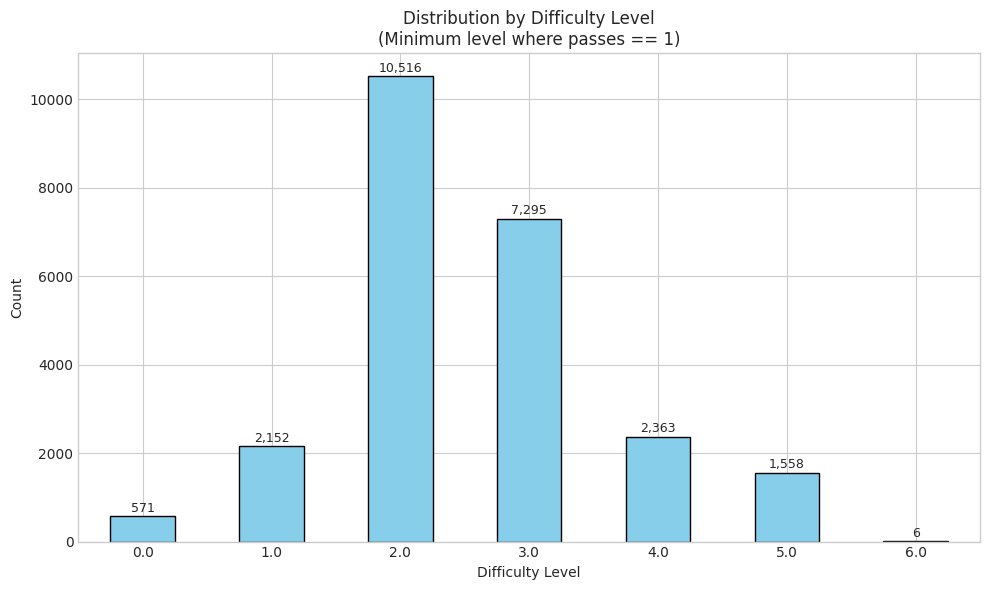

In [31]:
# Analyze difficulty level distribution
if 'difficulty_level' in df.columns and df['difficulty_level'].notna().any():
    df_with_diff = df[df['difficulty_level'].notna()].copy()
    df_without_diff = df[df['difficulty_level'].isna()].copy()
    
    print(f"\nRecords with difficulty level: {len(df_with_diff):,} ({len(df_with_diff)/len(df)*100:.1f}%)")
    print(f"Records without difficulty level: {len(df_without_diff):,} ({len(df_without_diff)/len(df)*100:.1f}%)")
    print(f"\n  Note: Difficulty level is extracted as the minimum level where passes == 1")
    print(f"        Records without difficulty have no computation_buckets with passes == 1")
    
    diff_counts = df_with_diff['difficulty_level'].value_counts().sort_index()
    print("\nDifficulty Level Distribution (for records with difficulty):")
    print(diff_counts)
    
    # Plot difficulty distribution
    fig, ax = plt.subplots(figsize=(10, 6))
    diff_counts.plot(kind='bar', ax=ax, color='skyblue', edgecolor='black')
    ax.set_xlabel('Difficulty Level')
    ax.set_ylabel('Count')
    ax.set_title('Distribution by Difficulty Level\n(Minimum level where passes == 1)')
    plt.xticks(rotation=0)
    for i, v in enumerate(diff_counts.values):
        ax.text(i, v + max(diff_counts.values)*0.01, f'{v:,}', ha='center', fontsize=9)
    plt.tight_layout()
    plt.show()
else:
    print("\nNo difficulty level data available")

## Difficulty Level vs Attempts (pass_at_k)

Records with both difficulty_level and pass_at_k: 24,412

pass_at_k distribution:
pass_at_k
1.0    22282
2.0     1663
3.0      394
4.0       73
Name: count, dtype: int64

Difficulty Level vs pass_at_k (counts):
pass_at_k            1    2    3   4
Difficulty Level                    
0                  545   23    1   2
1                 2039   92   13   5
2                 9635  685  141  32
3                 6519  573  165  23
4                 2167  144   42   6
5                 1372  145   32   5
6                    5    1    0   0

Difficulty Level vs pass_at_k (% within level):
pass_at_k            1     2    3    4
difficulty_level                      
0                 95.4   4.0  0.2  0.4
1                 94.9   4.3  0.6  0.2
2                 91.8   6.5  1.3  0.3
3                 89.5   7.9  2.3  0.3
4                 91.9   6.1  1.8  0.3
5                 88.3   9.3  2.1  0.3
6                 83.3  16.7  0.0  0.0


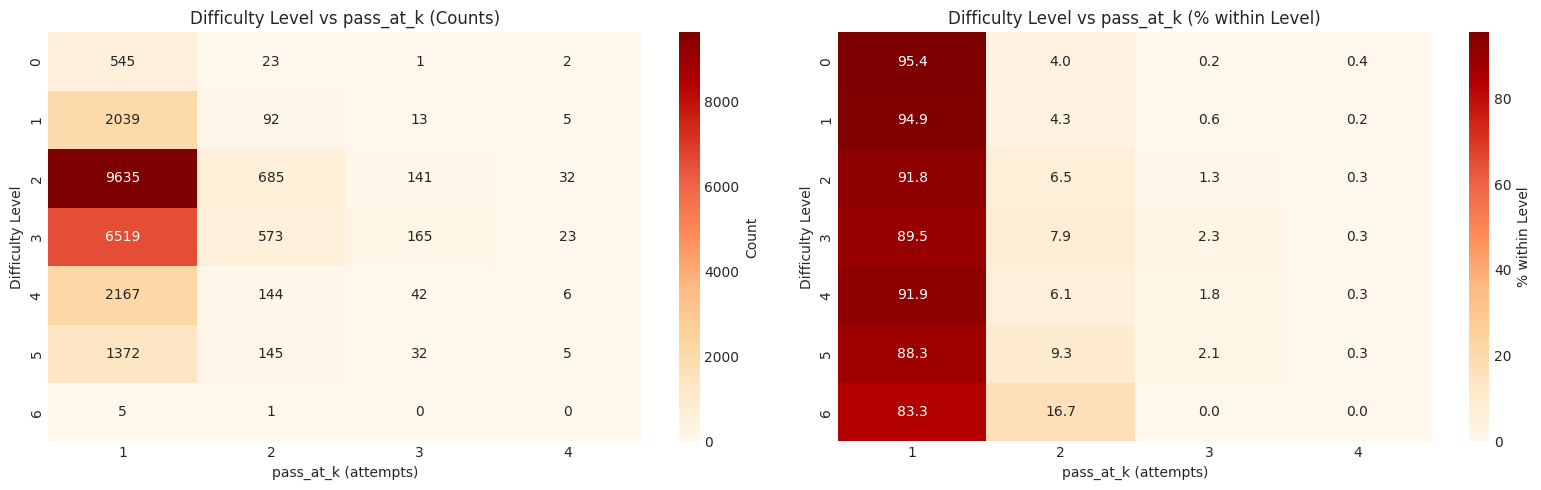

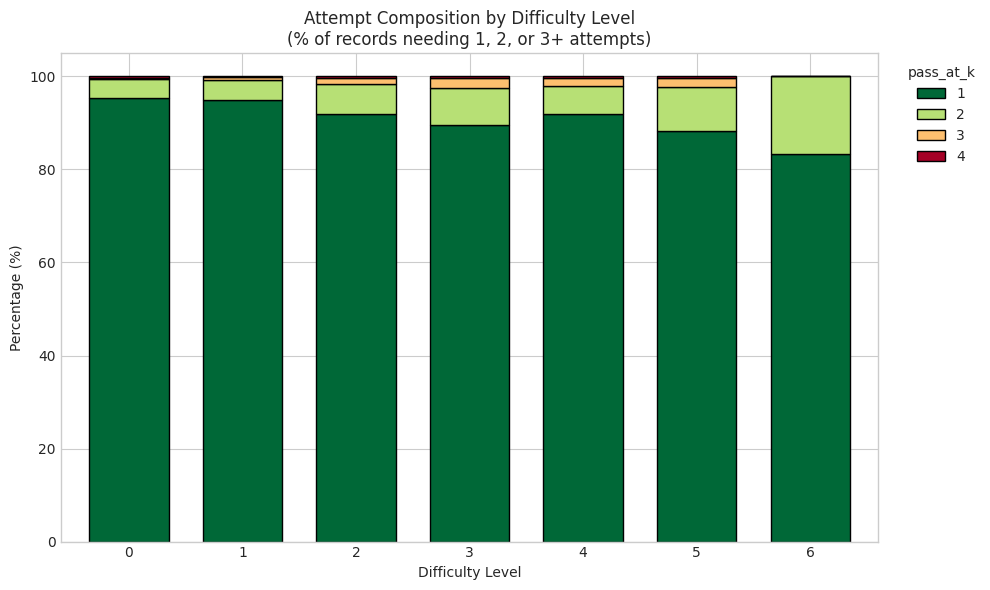

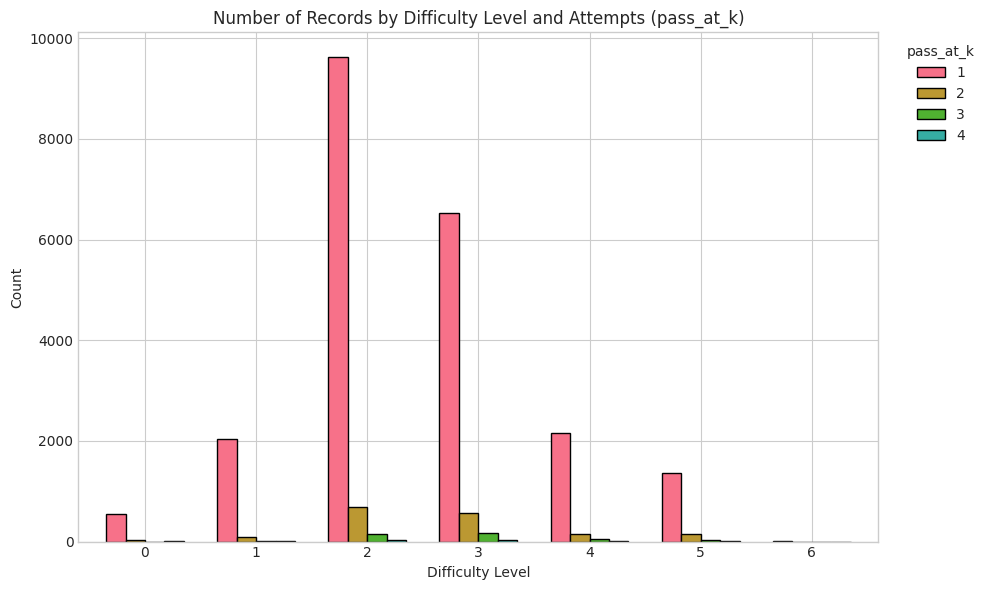


Average pass_at_k by Difficulty Level:
                   mean  median  count
difficulty_level                      
0                 1.054     1.0    571
1                 1.062     1.0   2149
2                 1.101     1.0  10493
3                 1.134     1.0   7280
4                 1.104     1.0   2359
5                 1.144     1.0   1554
6                 1.167     1.0      6


In [32]:
# Difficulty Level vs pass_at_k (number of attempts to solve)
df_dk = df[df['difficulty_level'].notna() & df['pass_at_k'].notna()].copy()
print(f"Records with both difficulty_level and pass_at_k: {len(df_dk):,}")
print(f"\npass_at_k distribution:")
print(df_dk['pass_at_k'].value_counts().sort_index())

# Cross-tabulation
cross_dk = pd.crosstab(df_dk['difficulty_level'], df_dk['pass_at_k'])
cross_dk.index = cross_dk.index.astype(int)
cross_dk.columns = cross_dk.columns.astype(int)
cross_dk.index.name = 'Difficulty Level'
cross_dk.columns.name = 'pass_at_k'
print("\nDifficulty Level vs pass_at_k (counts):")
print(cross_dk)

# Normalized: % within each difficulty level
cross_dk_pct = pd.crosstab(df_dk['difficulty_level'], df_dk['pass_at_k'], normalize='index') * 100
cross_dk_pct.index = cross_dk_pct.index.astype(int)
cross_dk_pct.columns = cross_dk_pct.columns.astype(int)
print("\nDifficulty Level vs pass_at_k (% within level):")
print(cross_dk_pct.round(1))

# --- Plot 1: Heatmaps side by side ---
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

sns.heatmap(cross_dk, annot=True, fmt='d', cmap='OrRd', ax=axes[0],
            cbar_kws={'label': 'Count'})
axes[0].set_title('Difficulty Level vs pass_at_k (Counts)')
axes[0].set_xlabel('pass_at_k (attempts)')
axes[0].set_ylabel('Difficulty Level')

sns.heatmap(cross_dk_pct, annot=True, fmt='.1f', cmap='OrRd', ax=axes[1],
            cbar_kws={'label': '% within Level'})
axes[1].set_title('Difficulty Level vs pass_at_k (% within Level)')
axes[1].set_xlabel('pass_at_k (attempts)')
axes[1].set_ylabel('Difficulty Level')

plt.tight_layout()
plt.show()

# --- Plot 2: 100% stacked bar showing attempt composition per level ---
fig, ax = plt.subplots(figsize=(10, 6))
cross_dk_pct.plot(kind='bar', stacked=True, ax=ax, edgecolor='black', width=0.7,
                  colormap='RdYlGn_r')
ax.set_xlabel('Difficulty Level')
ax.set_ylabel('Percentage (%)')
ax.set_title('Attempt Composition by Difficulty Level\n(% of records needing 1, 2, or 3+ attempts)')
ax.legend(title='pass_at_k', bbox_to_anchor=(1.02, 1), loc='upper left')
ax.set_ylim(0, 105)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# --- Plot 3: Grouped bar chart (raw counts) ---
fig, ax = plt.subplots(figsize=(10, 6))
cross_dk.plot(kind='bar', ax=ax, edgecolor='black', width=0.7)
ax.set_xlabel('Difficulty Level')
ax.set_ylabel('Count')
ax.set_title('Number of Records by Difficulty Level and Attempts (pass_at_k)')
ax.legend(title='pass_at_k', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# --- Summary: average pass_at_k per level ---
avg_pak = df_dk.groupby('difficulty_level')['pass_at_k'].agg(['mean', 'median', 'count'])
avg_pak.index = avg_pak.index.astype(int)
print("\nAverage pass_at_k by Difficulty Level:")
print(avg_pak.round(3))

## Domain Distribution

In [33]:
# Filter to records with domain information
if 'domain' in df.columns:
    df_with_domain = df[df['domain'].notna()].copy()
    print(f"\nRecords with domain: {len(df_with_domain):,} ({len(df_with_domain)/len(df)*100:.1f}%)")
else:
    df_with_domain = pd.DataFrame()
    print("\nNo domain column found in dataset")


Records with domain: 71,724 (99.8%)



Domain Distribution:
domain
number_theory    20567
algebra          19174
geometry         16898
combinatorics    13591
mixed             1494
Name: count, dtype: int64


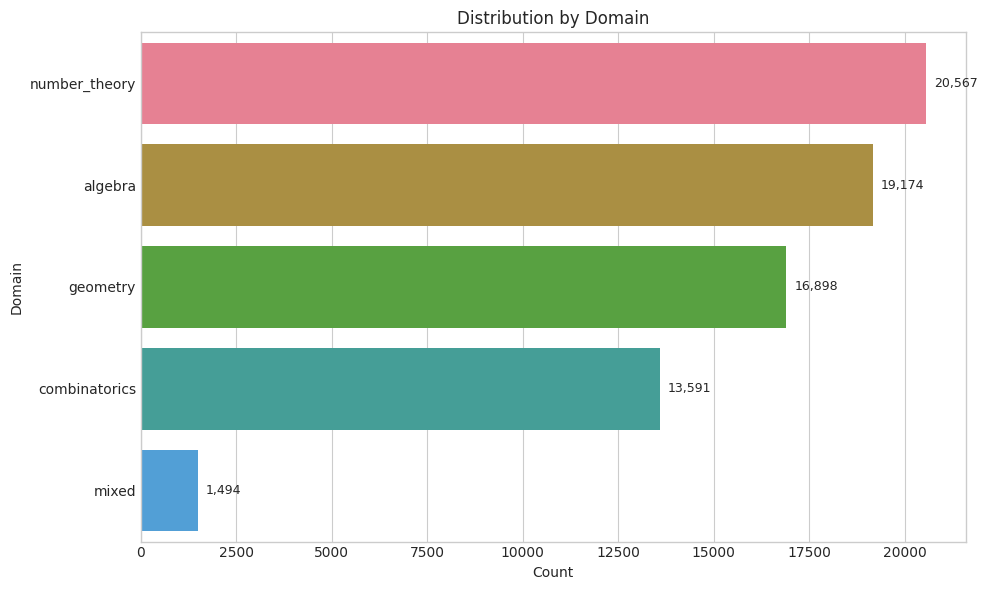

In [34]:
# Domain distribution
if len(df_with_domain) > 0:
    domain_counts = df_with_domain['domain'].value_counts()
    print("\nDomain Distribution:")
    print(domain_counts)
    
    # Plot domain distribution
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.barplot(x=domain_counts.values, y=domain_counts.index, ax=ax, hue=domain_counts.index, legend=False)
    ax.set_xlabel('Count')
    ax.set_ylabel('Domain')
    ax.set_title('Distribution by Domain')
    for i, v in enumerate(domain_counts.values):
        ax.text(v + max(domain_counts.values)*0.01, i, f'{v:,}', va='center', fontsize=9)
    plt.tight_layout()
    plt.show()
else:
    print("No domain data available for analysis")

## Domain vs Difficulty Level


Records with both domain and difficulty: 24,426

Domain vs Difficulty Level:
difficulty_level  0.0  1.0   2.0   3.0  4.0  5.0  6.0
domain                                               
algebra           126  921  4072  2544  632  466    4
combinatorics      56  262  1649  1363  509  336    1
geometry           26   81   707   699  238  296    0
mixed               3   18   127    80   35   29    1
number_theory     359  869  3952  2592  945  428    0


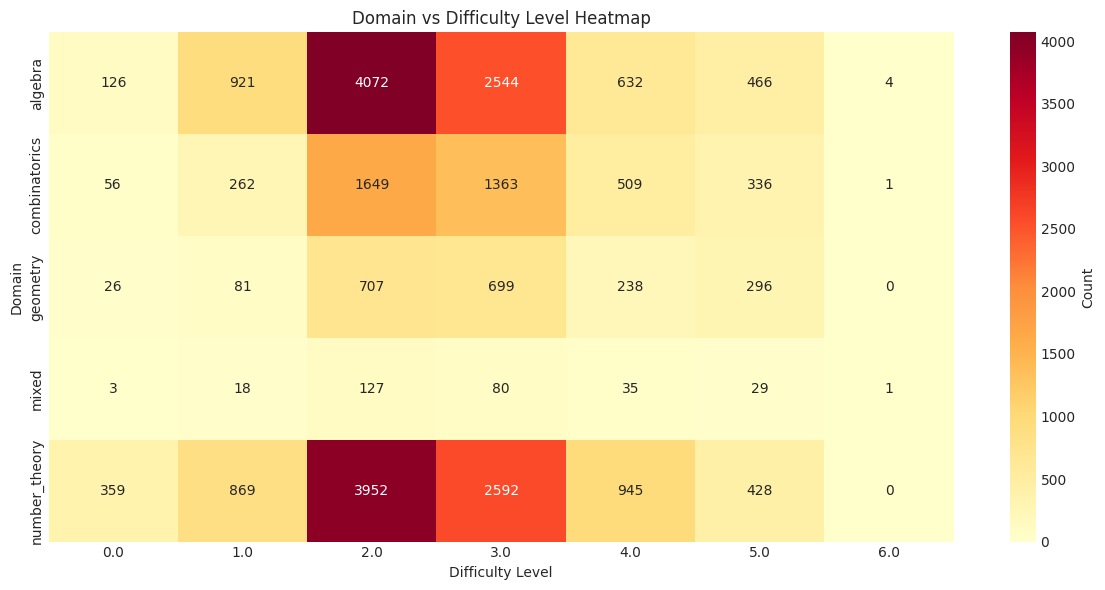


Average Difficulty by Domain:
                   mean  median  count
domain                                
geometry       2.942843     3.0   2047
mixed          2.740614     2.0    293
combinatorics  2.722941     3.0   4176
algebra        2.461951     2.0   8765
number_theory  2.456971     2.0   9145


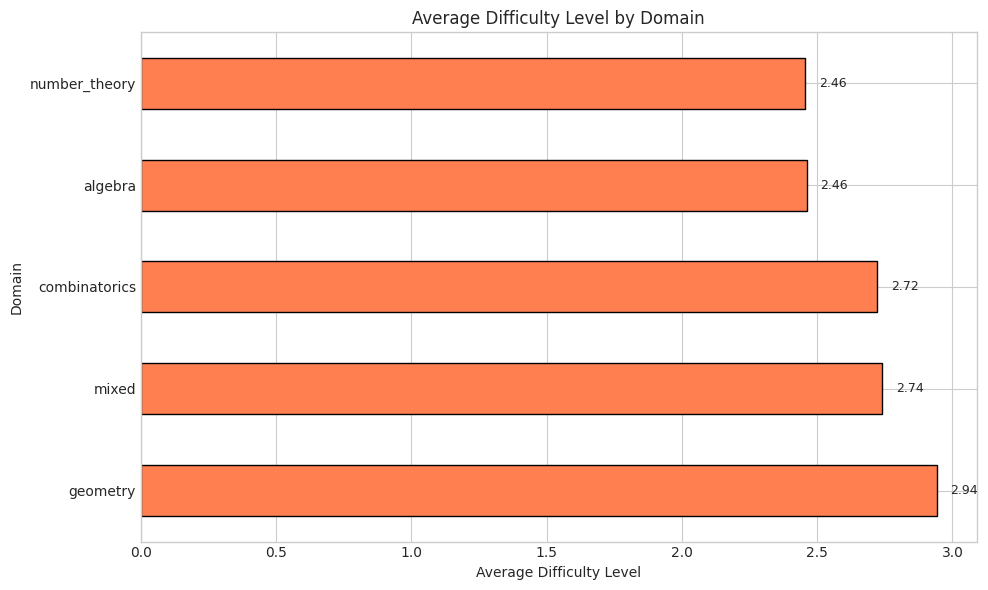

In [35]:
# Cross-tabulation: Domain vs Difficulty Level
if 'domain' in df.columns and 'difficulty_level' in df.columns:
    df_valid = df[df['domain'].notna() & df['difficulty_level'].notna()].copy()
    if len(df_valid) > 0:
        print(f"\nRecords with both domain and difficulty: {len(df_valid):,}")
        
        cross_tab = pd.crosstab(df_valid['domain'], df_valid['difficulty_level'])
        print("\nDomain vs Difficulty Level:")
        print(cross_tab)
        
        # Heatmap
        fig, ax = plt.subplots(figsize=(12, 6))
        sns.heatmap(cross_tab, annot=True, fmt='d', cmap='YlOrRd', ax=ax, cbar_kws={'label': 'Count'})
        ax.set_title('Domain vs Difficulty Level Heatmap')
        ax.set_xlabel('Difficulty Level')
        ax.set_ylabel('Domain')
        plt.tight_layout()
        plt.show()
        
        # Average difficulty by domain
        avg_diff_by_domain = df_valid.groupby('domain')['difficulty_level'].agg(['mean', 'median', 'count'])
        avg_diff_by_domain = avg_diff_by_domain.sort_values('mean', ascending=False)
        print("\nAverage Difficulty by Domain:")
        print(avg_diff_by_domain)
        
        # Plot average difficulty
        fig, ax = plt.subplots(figsize=(10, 6))
        avg_diff_by_domain['mean'].plot(kind='barh', ax=ax, color='coral', edgecolor='black')
        ax.set_xlabel('Average Difficulty Level')
        ax.set_ylabel('Domain')
        ax.set_title('Average Difficulty Level by Domain')
        for i, v in enumerate(avg_diff_by_domain['mean'].values):
            ax.text(v + 0.05, i, f'{v:.2f}', va='center', fontsize=9)
        plt.tight_layout()
        plt.show()
    else:
        print("Not enough data for cross-tabulation")
else:
    print("Domain or difficulty level data not available")

## Text Complexity Analysis


Records with text complexity data: 71,761

Text Complexity Statistics:
       mechanisms_count  constraints_count  objects_count
count      71761.000000       71761.000000   71761.000000
mean           0.001059           1.617926       1.634802
std            0.032526           0.990748       0.697226
min            0.000000           0.000000       0.000000
25%            0.000000           1.000000       1.000000
50%            0.000000           2.000000       2.000000
75%            0.000000           2.000000       2.000000
max            1.000000          10.000000      10.000000


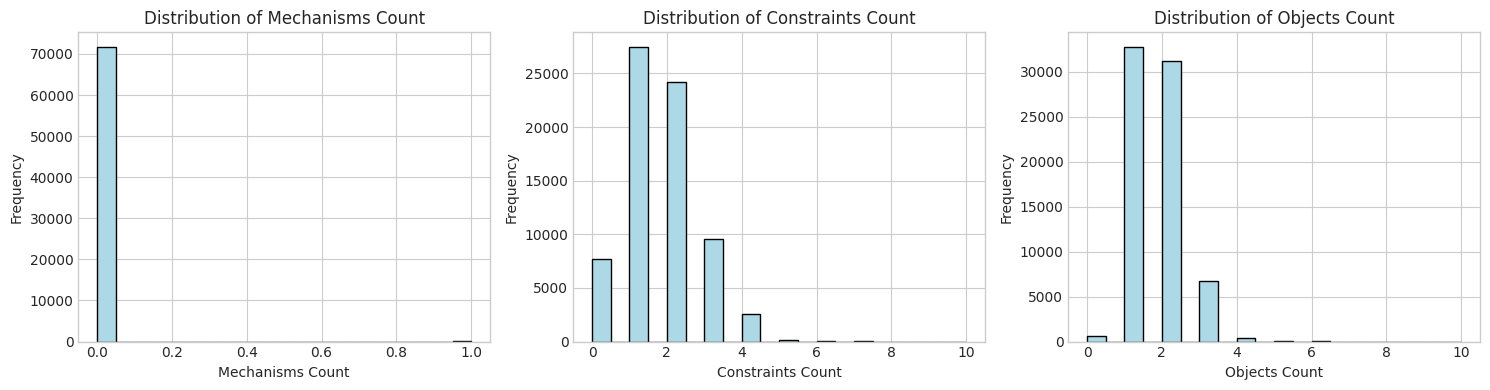


Correlation with Difficulty Level:
  mechanisms_count: -0.007
  constraints_count: 0.099
  objects_count: 0.056


In [36]:
# Analyze mechanisms, constraints, and objects counts
if all(col in df.columns for col in ['mechanisms_count', 'constraints_count', 'objects_count']):
    df_with_counts = df[
        df['mechanisms_count'].notna() & 
        df['constraints_count'].notna() & 
        df['objects_count'].notna()
    ].copy()
else:
    df_with_counts = pd.DataFrame()

if len(df_with_counts) > 0:
    print(f"\nRecords with text complexity data: {len(df_with_counts):,}")
    print("\nText Complexity Statistics:")
    print(df_with_counts[['mechanisms_count', 'constraints_count', 'objects_count']].describe())
    
    # Plot distributions
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    for idx, col in enumerate(['mechanisms_count', 'constraints_count', 'objects_count']):
        df_with_counts[col].hist(bins=20, ax=axes[idx], edgecolor='black', color='lightblue')
        axes[idx].set_xlabel(col.replace('_', ' ').title())
        axes[idx].set_ylabel('Frequency')
        axes[idx].set_title(f'Distribution of {col.replace("_", " ").title()}')
    
    plt.tight_layout()
    plt.show()
    
    # Correlation with difficulty
    if 'difficulty_level' in df_with_counts.columns:
        df_corr = df_with_counts[df_with_counts['difficulty_level'].notna()].copy()
        if len(df_corr) > 0:
            print("\nCorrelation with Difficulty Level:")
            for col in ['mechanisms_count', 'constraints_count', 'objects_count']:
                corr = df_corr[col].corr(df_corr['difficulty_level'])
                print(f"  {col}: {corr:.3f}")
else:
    print("No text complexity data available")

## Constraints, Objects & Reasoning Depth vs Difficulty Level


Constraints Count vs Difficulty Level  (n=24,435)
        mean  median    std  count
level                             
0      0.900     1.0  0.779    570
1      1.193     1.0  0.817   2151
2      1.304     1.0  0.876  10510
3      1.433     1.0  0.903   7281
4      1.407     1.0  0.922   2360
5      1.455     1.0  0.942   1557
6      1.333     1.5  0.816      6


/tmp/ipykernel_3942/631598004.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_sub, x='level', y=col, ax=axes[0],


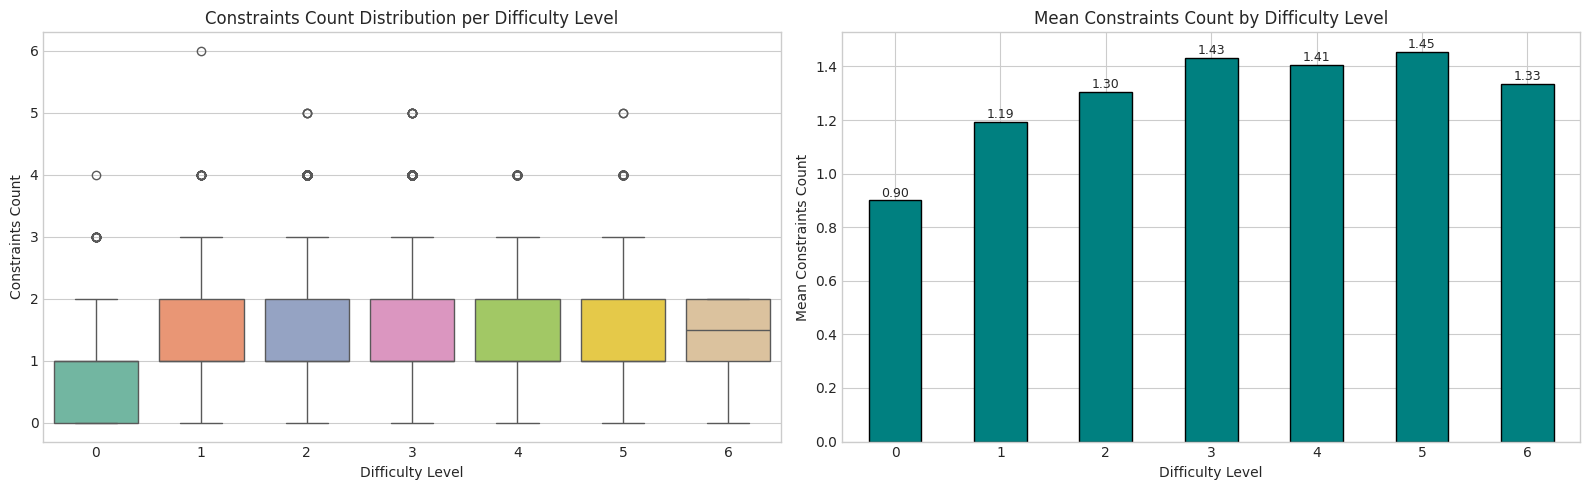


Objects Count vs Difficulty Level  (n=24,435)
        mean  median    std  count
level                             
0      1.295     1.0  0.497    570
1      1.378     1.0  0.519   2151
2      1.452     1.0  0.569  10510
3      1.492     1.0  0.596   7281
4      1.489     1.0  0.599   2360
5      1.480     1.0  0.640   1557
6      1.667     2.0  0.516      6


/tmp/ipykernel_3942/631598004.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_sub, x='level', y=col, ax=axes[0],


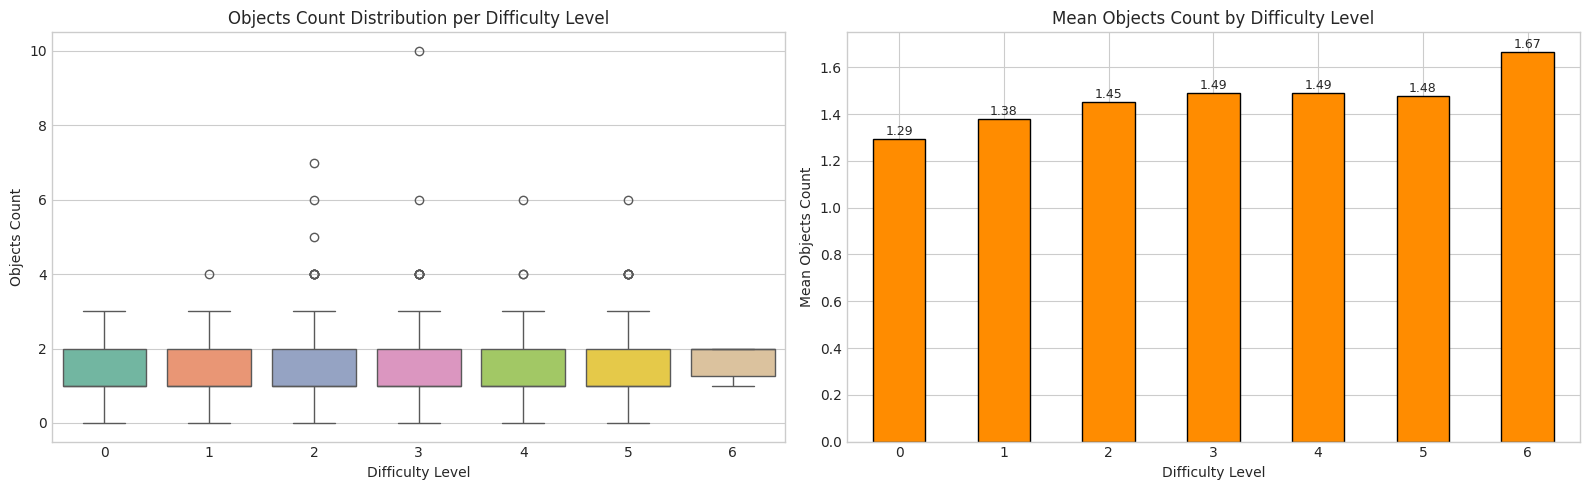


Reasoning Depth vs Difficulty Level  (n=24,205)

Counts:
difficulty_level  0.0   1.0   2.0   3.0   4.0   5.0  6.0
reasoning_depth                                         
deep               71   106   893   777   241   145    0
medium            313   993  6198  4721  1495  1004    3
null                0     0     1     0     0     0    0
shallow           187  1034  3301  1716   610   393    3

% within each difficulty level:
difficulty_level   0.0   1.0   2.0   3.0   4.0   5.0   6.0
reasoning_depth                                           
deep              12.4   5.0   8.6  10.8  10.3   9.4   0.0
medium            54.8  46.6  59.6  65.4  63.7  65.1  50.0
null               0.0   0.0   0.0   0.0   0.0   0.0   0.0
shallow           32.7  48.5  31.8  23.8  26.0  25.5  50.0


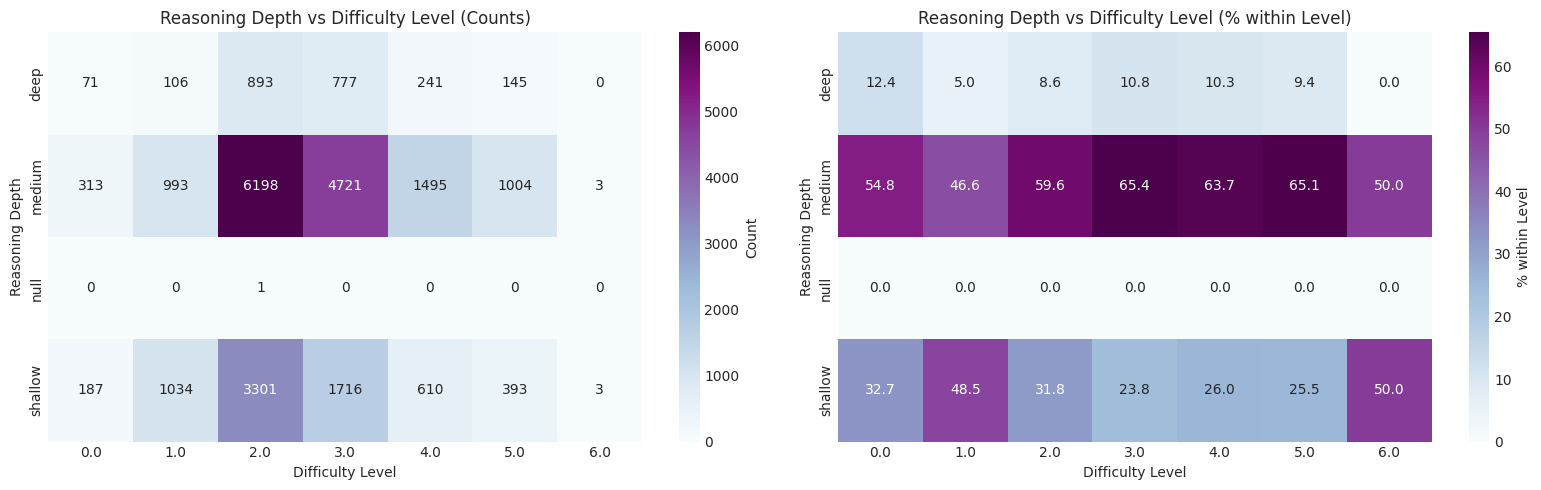

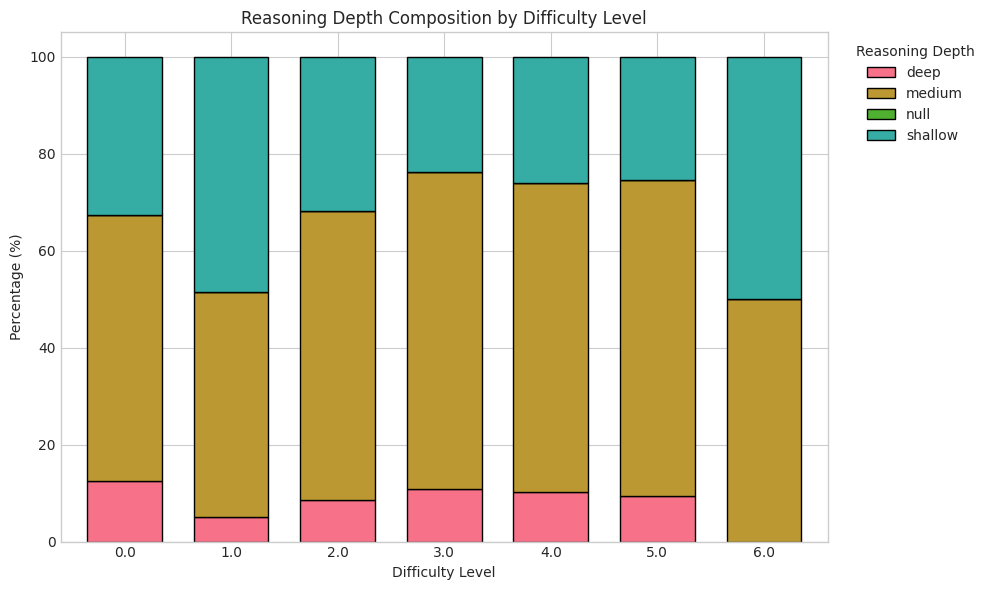

In [37]:
# ── Helper: numeric feature vs difficulty level breakdown ──
def plot_numeric_vs_difficulty(df, col, label, color='steelblue'):
    """Box plot + mean bar chart for a numeric column grouped by difficulty level."""
    df_sub = df[df[col].notna() & df['difficulty_level'].notna()].copy()
    df_sub['level'] = df_sub['difficulty_level'].astype(int)
    levels = sorted(df_sub['level'].unique())
    print(f"\n{'='*60}")
    print(f"{label} vs Difficulty Level  (n={len(df_sub):,})")
    print(f"{'='*60}")

    stats = df_sub.groupby('level')[col].agg(['mean', 'median', 'std', 'count'])
    print(stats.round(3))

    fig, axes = plt.subplots(1, 2, figsize=(16, 5))

    # Box plot
    sns.boxplot(data=df_sub, x='level', y=col, ax=axes[0],
                order=levels, palette='Set2')
    axes[0].set_xlabel('Difficulty Level')
    axes[0].set_ylabel(label)
    axes[0].set_title(f'{label} Distribution per Difficulty Level')

    # Mean bar chart
    stats['mean'].plot(kind='bar', ax=axes[1], color=color, edgecolor='black')
    axes[1].set_xlabel('Difficulty Level')
    axes[1].set_ylabel(f'Mean {label}')
    axes[1].set_title(f'Mean {label} by Difficulty Level')
    for i, v in enumerate(stats['mean'].values):
        axes[1].text(i, v + stats['mean'].max() * 0.01, f'{v:.2f}', ha='center', fontsize=9)
    axes[1].tick_params(axis='x', rotation=0)

    plt.tight_layout()
    plt.show()


# ── Helper: categorical feature vs difficulty level breakdown ──
def plot_categorical_vs_difficulty(df, col, label, cmap='YlOrBr'):
    """Heatmap + stacked bar for a categorical column grouped by difficulty level."""
    df_sub = df[df[col].notna() & df['difficulty_level'].notna()].copy()
    print(f"\n{'='*60}")
    print(f"{label} vs Difficulty Level  (n={len(df_sub):,})")
    print(f"{'='*60}")

    cross = pd.crosstab(df_sub[col], df_sub['difficulty_level'])
    cross_pct = pd.crosstab(df_sub[col], df_sub['difficulty_level'], normalize='columns') * 100
    print("\nCounts:")
    print(cross)
    print(f"\n% within each difficulty level:")
    print(cross_pct.round(1))

    fig, axes = plt.subplots(1, 2, figsize=(16, 5))

    sns.heatmap(cross, annot=True, fmt='d', cmap=cmap, ax=axes[0],
                cbar_kws={'label': 'Count'})
    axes[0].set_title(f'{label} vs Difficulty Level (Counts)')
    axes[0].set_xlabel('Difficulty Level')
    axes[0].set_ylabel(label)

    sns.heatmap(cross_pct, annot=True, fmt='.1f', cmap=cmap, ax=axes[1],
                cbar_kws={'label': '% within Level'})
    axes[1].set_title(f'{label} vs Difficulty Level (% within Level)')
    axes[1].set_xlabel('Difficulty Level')
    axes[1].set_ylabel(label)

    plt.tight_layout()
    plt.show()

    # Stacked bar (composition per level)
    cross_pct_t = cross_pct.T
    fig, ax = plt.subplots(figsize=(10, 6))
    cross_pct_t.plot(kind='bar', stacked=True, ax=ax, edgecolor='black', width=0.7)
    ax.set_xlabel('Difficulty Level')
    ax.set_ylabel('Percentage (%)')
    ax.set_title(f'{label} Composition by Difficulty Level')
    ax.legend(title=label, bbox_to_anchor=(1.02, 1), loc='upper left')
    ax.set_ylim(0, 105)
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()


# ── 1. Constraints Count vs Difficulty Level ──
plot_numeric_vs_difficulty(df, 'constraints_count', 'Constraints Count', color='teal')

# ── 2. Objects Count vs Difficulty Level ──
plot_numeric_vs_difficulty(df, 'objects_count', 'Objects Count', color='darkorange')

# ── 3. Reasoning Depth vs Difficulty Level ──
plot_categorical_vs_difficulty(df, 'reasoning_depth', 'Reasoning Depth', cmap='BuPu')

## Solution Properties Analysis


Reasoning Depth Distribution:
reasoning_depth
medium     46182
shallow    14430
deep       10806
null           2
Name: count, dtype: int64


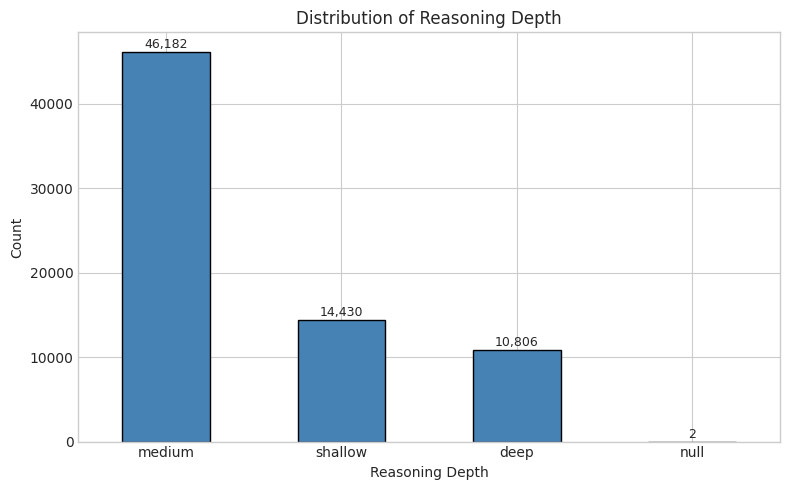


Reasoning Depth vs Difficulty Level:
difficulty_level  0.0   1.0   2.0   3.0   4.0   5.0  6.0
reasoning_depth                                         
deep               71   106   893   777   241   145    0
medium            313   993  6198  4721  1495  1004    3
null                0     0     1     0     0     0    0
shallow           187  1034  3301  1716   610   393    3


In [38]:
# Analyze reasoning depth
if 'reasoning_depth' in df.columns and df['reasoning_depth'].notna().any():
    depth_counts = df['reasoning_depth'].value_counts()
    print("\nReasoning Depth Distribution:")
    print(depth_counts)
    
    fig, ax = plt.subplots(figsize=(8, 5))
    depth_counts.plot(kind='bar', ax=ax, color='steelblue', edgecolor='black')
    ax.set_xlabel('Reasoning Depth')
    ax.set_ylabel('Count')
    ax.set_title('Distribution of Reasoning Depth')
    plt.xticks(rotation=0)
    for i, v in enumerate(depth_counts.values):
        ax.text(i, v + max(depth_counts.values)*0.01, f'{v:,}', ha='center', fontsize=9)
    plt.tight_layout()
    plt.show()
    
    # Reasoning depth vs difficulty
    if 'difficulty_level' in df.columns:
        df_rd = df[df['reasoning_depth'].notna() & df['difficulty_level'].notna()].copy()
        if len(df_rd) > 0:
            cross_tab_rd = pd.crosstab(df_rd['reasoning_depth'], df_rd['difficulty_level'])
            print("\nReasoning Depth vs Difficulty Level:")
            print(cross_tab_rd)
else:
    print("No reasoning depth data available")


Case Split Distribution:
case_split
none      68723
binary     2155
multi       574
null          1
Name: count, dtype: int64


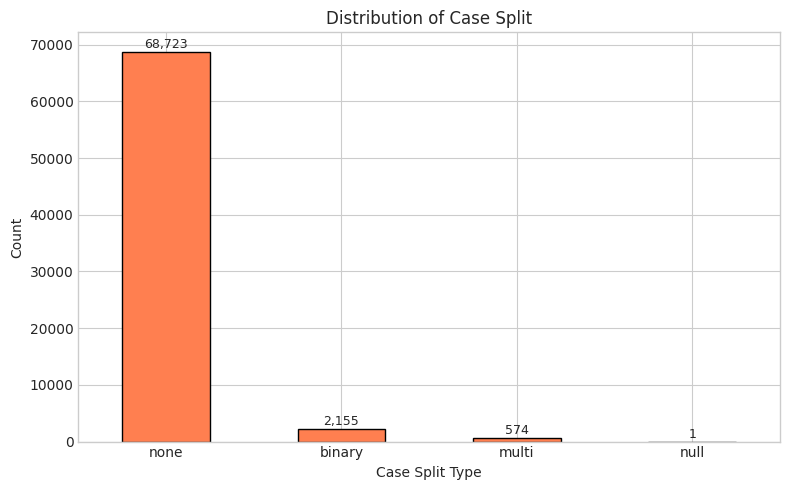

In [39]:
# Analyze case split
if 'case_split' in df.columns and df['case_split'].notna().any():
    case_split_counts = df['case_split'].value_counts()
    print("\nCase Split Distribution:")
    print(case_split_counts)
    
    fig, ax = plt.subplots(figsize=(8, 5))
    case_split_counts.plot(kind='bar', ax=ax, color='coral', edgecolor='black')
    ax.set_xlabel('Case Split Type')
    ax.set_ylabel('Count')
    ax.set_title('Distribution of Case Split')
    plt.xticks(rotation=0)
    for i, v in enumerate(case_split_counts.values):
        ax.text(i, v + max(case_split_counts.values)*0.01, f'{v:,}', ha='center', fontsize=9)
    plt.tight_layout()
    plt.show()
else:
    print("No case split data available")


Reasoning Shape Distribution:
reasoning_shape
linear                    70534
branching                   860
multi_branch_recombine       15
null                          2
deep                          1
none                          1
Name: count, dtype: int64


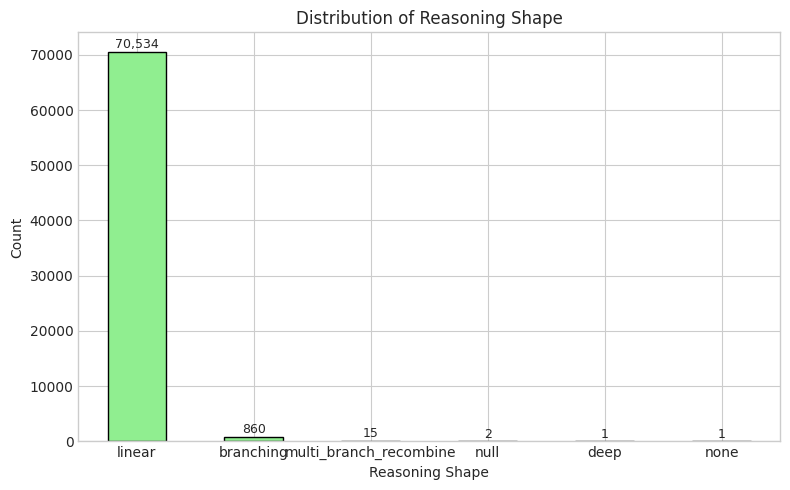

In [40]:
# Analyze reasoning shape
if 'reasoning_shape' in df.columns and df['reasoning_shape'].notna().any():
    shape_counts = df['reasoning_shape'].value_counts()
    print("\nReasoning Shape Distribution:")
    print(shape_counts)
    
    fig, ax = plt.subplots(figsize=(8, 5))
    shape_counts.plot(kind='bar', ax=ax, color='lightgreen', edgecolor='black')
    ax.set_xlabel('Reasoning Shape')
    ax.set_ylabel('Count')
    ax.set_title('Distribution of Reasoning Shape')
    plt.xticks(rotation=0)
    for i, v in enumerate(shape_counts.values):
        ax.text(i, v + max(shape_counts.values)*0.01, f'{v:,}', ha='center', fontsize=9)
    plt.tight_layout()
    plt.show()
else:
    print("No reasoning shape data available")


Constraints Distribution (individual values):
constraints
equality           41370
exists             20149
inequality         12765
distinct           10196
forall              9773
                   ...  
unity                  1
lcm                    1
exponentiation         1
not_consecutive        1
square-free            1
Name: count, Length: 438, dtype: int64


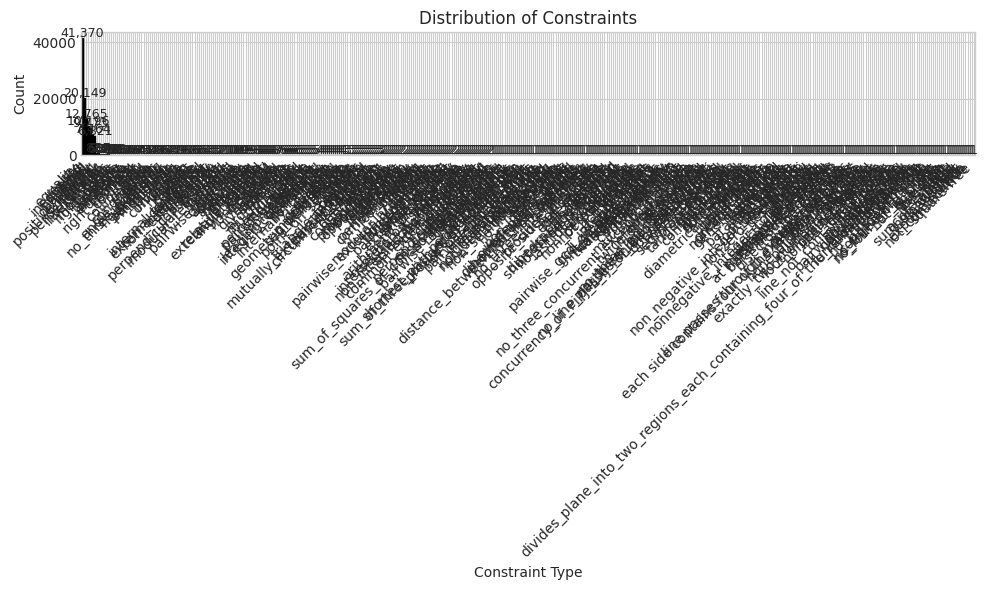

In [41]:
# Analyze constraints distribution (individual constraint values from list field)
if 'constraints' in df.columns and df['constraints'].apply(lambda x: isinstance(x, list) and len(x) > 0).any():
    all_constraints = df['constraints'].dropna().explode()
    all_constraints = all_constraints[all_constraints.apply(lambda x: isinstance(x, str) and x.strip() != '')]
    constraint_counts = all_constraints.value_counts()
    print("\nConstraints Distribution (individual values):")
    print(constraint_counts)

    fig, ax = plt.subplots(figsize=(10, 6))
    constraint_counts.plot(kind='bar', ax=ax, color='mediumpurple', edgecolor='black')
    ax.set_xlabel('Constraint Type')
    ax.set_ylabel('Count')
    ax.set_title('Distribution of Constraints')
    plt.xticks(rotation=45, ha='right')
    for i, v in enumerate(constraint_counts.values):
        ax.text(i, v + max(constraint_counts.values)*0.01, f'{v:,}', ha='center', fontsize=9)
    plt.tight_layout()
    plt.show()
else:
    print("No constraints data available")


Invariant Distribution:
invariant
none        70580
explicit      670
implicit      202
null            1
Name: count, dtype: int64


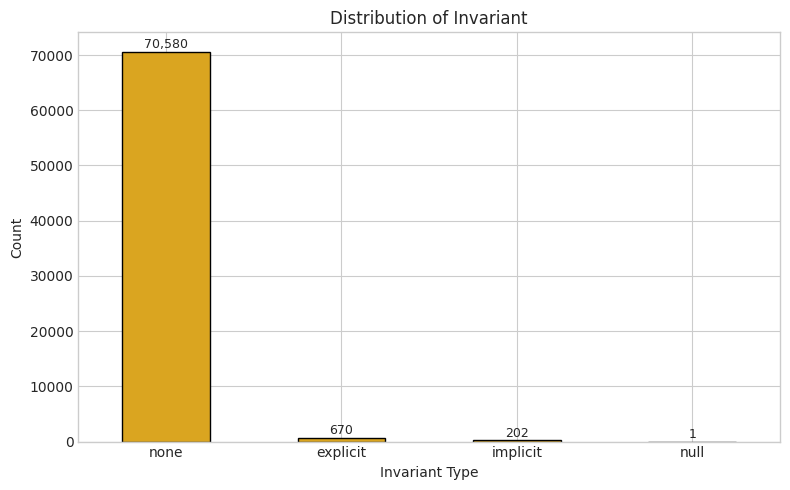

In [42]:
# Analyze invariant distribution
if 'invariant' in df.columns and df['invariant'].notna().any():
    invariant_counts = df['invariant'].value_counts()
    print("\nInvariant Distribution:")
    print(invariant_counts)

    fig, ax = plt.subplots(figsize=(8, 5))
    invariant_counts.plot(kind='bar', ax=ax, color='goldenrod', edgecolor='black')
    ax.set_xlabel('Invariant Type')
    ax.set_ylabel('Count')
    ax.set_title('Distribution of Invariant')
    plt.xticks(rotation=0)
    for i, v in enumerate(invariant_counts.values):
        ax.text(i, v + max(invariant_counts.values)*0.01, f'{v:,}', ha='center', fontsize=9)
    plt.tight_layout()
    plt.show()
else:
    print("No invariant data available")


Auxiliary Construction Distribution:
auxiliary_construction
symbolic      65498
none           4722
structural     1233
null              1
Name: count, dtype: int64


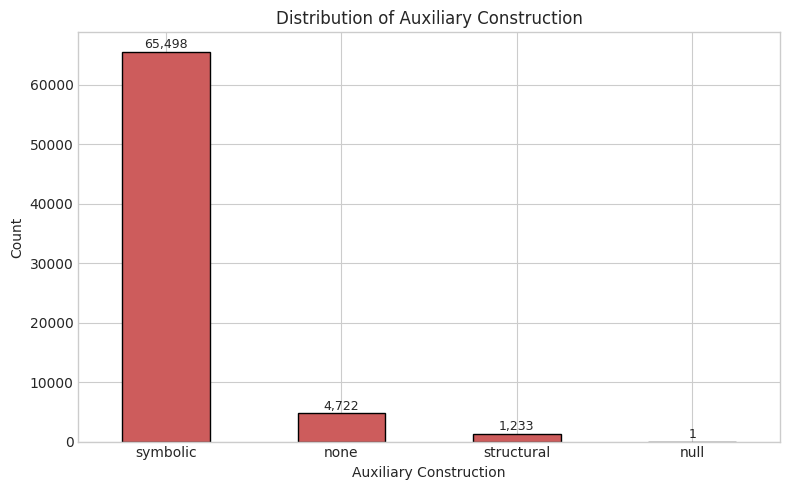

In [43]:
# Analyze auxiliary_construction distribution
if 'auxiliary_construction' in df.columns and df['auxiliary_construction'].notna().any():
    aux_counts = df['auxiliary_construction'].value_counts()
    print("\nAuxiliary Construction Distribution:")
    print(aux_counts)

    fig, ax = plt.subplots(figsize=(8, 5))
    aux_counts.plot(kind='bar', ax=ax, color='indianred', edgecolor='black')
    ax.set_xlabel('Auxiliary Construction')
    ax.set_ylabel('Count')
    ax.set_title('Distribution of Auxiliary Construction')
    plt.xticks(rotation=0)
    for i, v in enumerate(aux_counts.values):
        ax.text(i, v + max(aux_counts.values)*0.01, f'{v:,}', ha='center', fontsize=9)
    plt.tight_layout()
    plt.show()
else:
    print("No auxiliary_construction data available")


Technique Transitions Distribution:
technique_transitions
0       46180
1       12890
2       12400
3           1
null        1
Name: count, dtype: int64


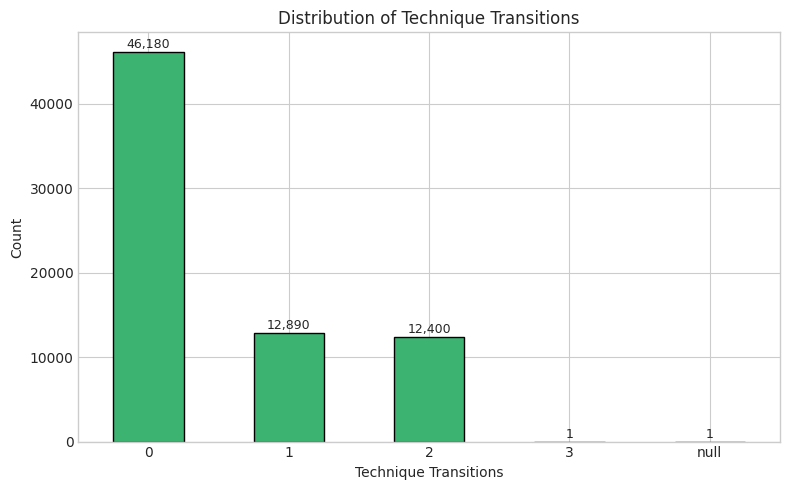

In [44]:
# Analyze technique_transitions distribution
if 'technique_transitions' in df.columns and df['technique_transitions'].notna().any():
    # Convert to string to handle mixed types, then get value counts
    tt_counts = df['technique_transitions'].astype(str).value_counts()
    
    # Try to sort numerically if possible, otherwise sort as strings
    try:
        # Attempt numeric sorting (puts integers first, then non-numeric strings)
        tt_counts = tt_counts.reindex(sorted(tt_counts.index, key=lambda x: (int(x) if x.isdigit() else float('inf'), x)))
    except (ValueError, TypeError):
        # Fall back to string sorting if numeric doesn't work
        tt_counts = tt_counts.sort_index()
    
    print("\nTechnique Transitions Distribution:")
    print(tt_counts)

    fig, ax = plt.subplots(figsize=(8, 5))
    tt_counts.plot(kind='bar', ax=ax, color='mediumseagreen', edgecolor='black')
    ax.set_xlabel('Technique Transitions')
    ax.set_ylabel('Count')
    ax.set_title('Distribution of Technique Transitions')
    plt.xticks(rotation=0)
    for i, v in enumerate(tt_counts.values):
        ax.text(i, v + max(tt_counts.values)*0.01, f'{v:,}', ha='center', fontsize=9)
    plt.tight_layout()
    plt.show()
else:
    print("No technique_transitions data available")


Argument Style Distribution:
argument_style
direct           69677
contradiction       79
none                49
inductive           12
null                 5
constructive         1
Name: count, dtype: int64


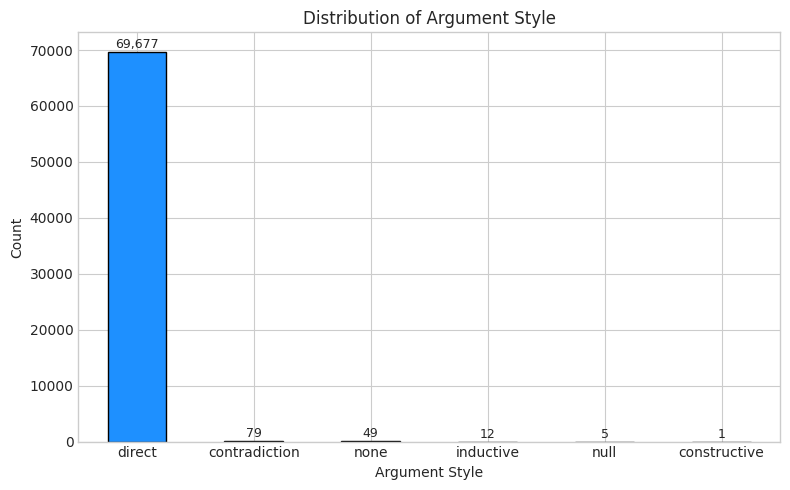

In [45]:
# Analyze argument_style distribution
if 'argument_style' in df.columns and df['argument_style'].notna().any():
    arg_counts = df['argument_style'].value_counts()
    print("\nArgument Style Distribution:")
    print(arg_counts)

    fig, ax = plt.subplots(figsize=(8, 5))
    arg_counts.plot(kind='bar', ax=ax, color='dodgerblue', edgecolor='black')
    ax.set_xlabel('Argument Style')
    ax.set_ylabel('Count')
    ax.set_title('Distribution of Argument Style')
    plt.xticks(rotation=0)
    for i, v in enumerate(arg_counts.values):
        ax.text(i, v + max(arg_counts.values)*0.01, f'{v:,}', ha='center', fontsize=9)
    plt.tight_layout()
    plt.show()
else:
    print("No argument_style data available")


Reasoning Scope Distribution:
reasoning_scope
local     56414
global    12976
mixed      2019
none          3
null          1
Name: count, dtype: int64


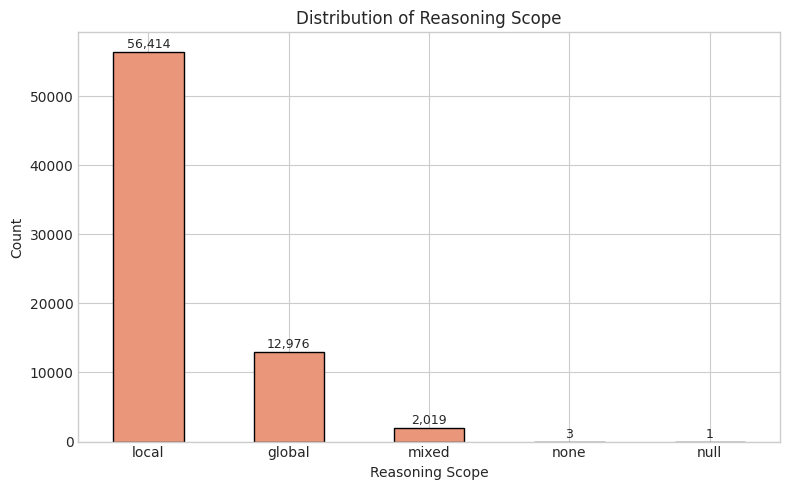

In [46]:
# Analyze reasoning_scope distribution
if 'reasoning_scope' in df.columns and df['reasoning_scope'].notna().any():
    scope_counts = df['reasoning_scope'].value_counts()
    print("\nReasoning Scope Distribution:")
    print(scope_counts)

    fig, ax = plt.subplots(figsize=(8, 5))
    scope_counts.plot(kind='bar', ax=ax, color='darksalmon', edgecolor='black')
    ax.set_xlabel('Reasoning Scope')
    ax.set_ylabel('Count')
    ax.set_title('Distribution of Reasoning Scope')
    plt.xticks(rotation=0)
    for i, v in enumerate(scope_counts.values):
        ax.text(i, v + max(scope_counts.values)*0.01, f'{v:,}', ha='center', fontsize=9)
    plt.tight_layout()
    plt.show()
else:
    print("No reasoning_scope data available")


Dead End Pruning Distribution:
dead_end_pruning
False    67712
True      3760
null         1
Name: count, dtype: int64


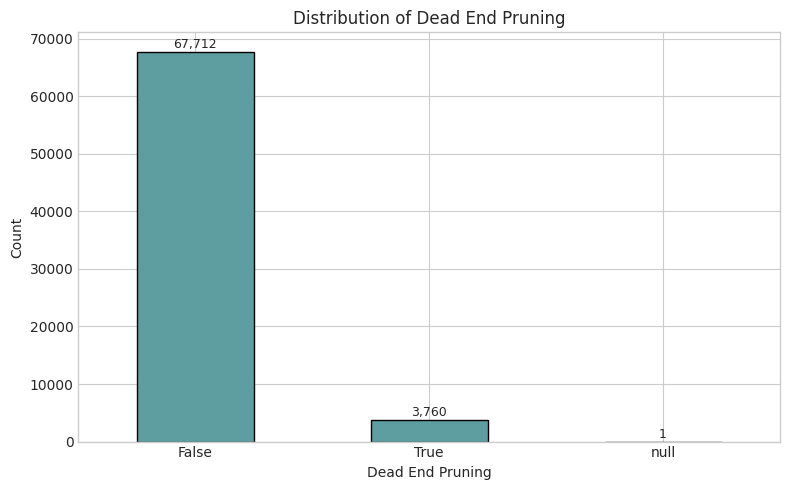

In [47]:
# Analyze dead_end_pruning distribution
if 'dead_end_pruning' in df.columns and df['dead_end_pruning'].notna().any():
    pruning_counts = df['dead_end_pruning'].value_counts()
    print("\nDead End Pruning Distribution:")
    print(pruning_counts)

    fig, ax = plt.subplots(figsize=(8, 5))
    pruning_counts.plot(kind='bar', ax=ax, color='cadetblue', edgecolor='black')
    ax.set_xlabel('Dead End Pruning')
    ax.set_ylabel('Count')
    ax.set_title('Distribution of Dead End Pruning')
    plt.xticks(rotation=0)
    for i, v in enumerate(pruning_counts.values):
        ax.text(i, v + max(pruning_counts.values)*0.01, f'{v:,}', ha='center', fontsize=9)
    plt.tight_layout()
    plt.show()
else:
    print("No dead_end_pruning data available")


Intermediate Reuse Distribution:
intermediate_reuse
single      33296
multiple    24107
none        14046
null            1
Name: count, dtype: int64


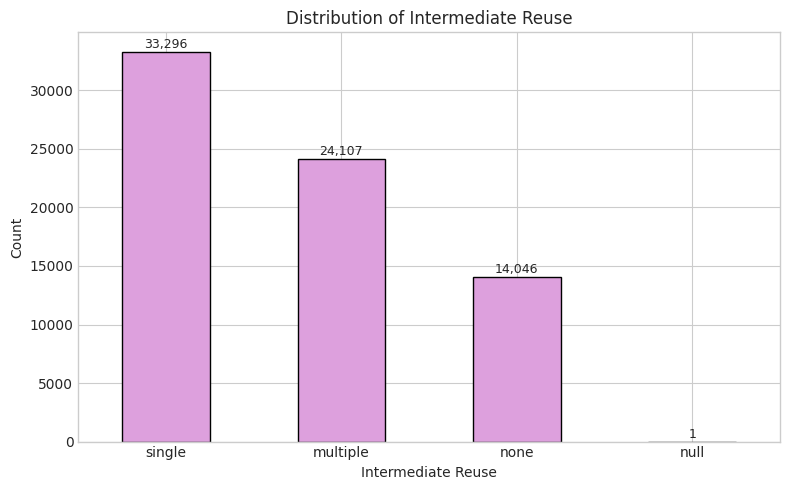

In [48]:
# Analyze intermediate_reuse distribution
if 'intermediate_reuse' in df.columns and df['intermediate_reuse'].notna().any():
    reuse_counts = df['intermediate_reuse'].value_counts()
    print("\nIntermediate Reuse Distribution:")
    print(reuse_counts)

    fig, ax = plt.subplots(figsize=(8, 5))
    reuse_counts.plot(kind='bar', ax=ax, color='plum', edgecolor='black')
    ax.set_xlabel('Intermediate Reuse')
    ax.set_ylabel('Count')
    ax.set_title('Distribution of Intermediate Reuse')
    plt.xticks(rotation=0)
    for i, v in enumerate(reuse_counts.values):
        ax.text(i, v + max(reuse_counts.values)*0.01, f'{v:,}', ha='center', fontsize=9)
    plt.tight_layout()
    plt.show()
else:
    print("No intermediate_reuse data available")

## Difficulty vs Reasoning Shape

Records with both difficulty and reasoning shape: 24,200

Difficulty Level vs Reasoning Shape (counts):
difficulty_level        0.0   1.0    2.0   3.0   4.0   5.0  6.0
reasoning_shape                                                
branching                 0     5     55    53    20    12    0
linear                  571  2127  10335  7158  2323  1530    6
multi_branch_recombine    0     0      1     1     2     0    0
null                      0     0      1     0     0     0    0

Difficulty Level vs Reasoning Shape (% within difficulty level):
difficulty_level          0.0   1.0   2.0   3.0   4.0   5.0    6.0
reasoning_shape                                                   
branching                 0.0   0.2   0.5   0.7   0.9   0.8    0.0
linear                  100.0  99.8  99.5  99.3  99.1  99.2  100.0
multi_branch_recombine    0.0   0.0   0.0   0.0   0.1   0.0    0.0
null                      0.0   0.0   0.0   0.0   0.0   0.0    0.0


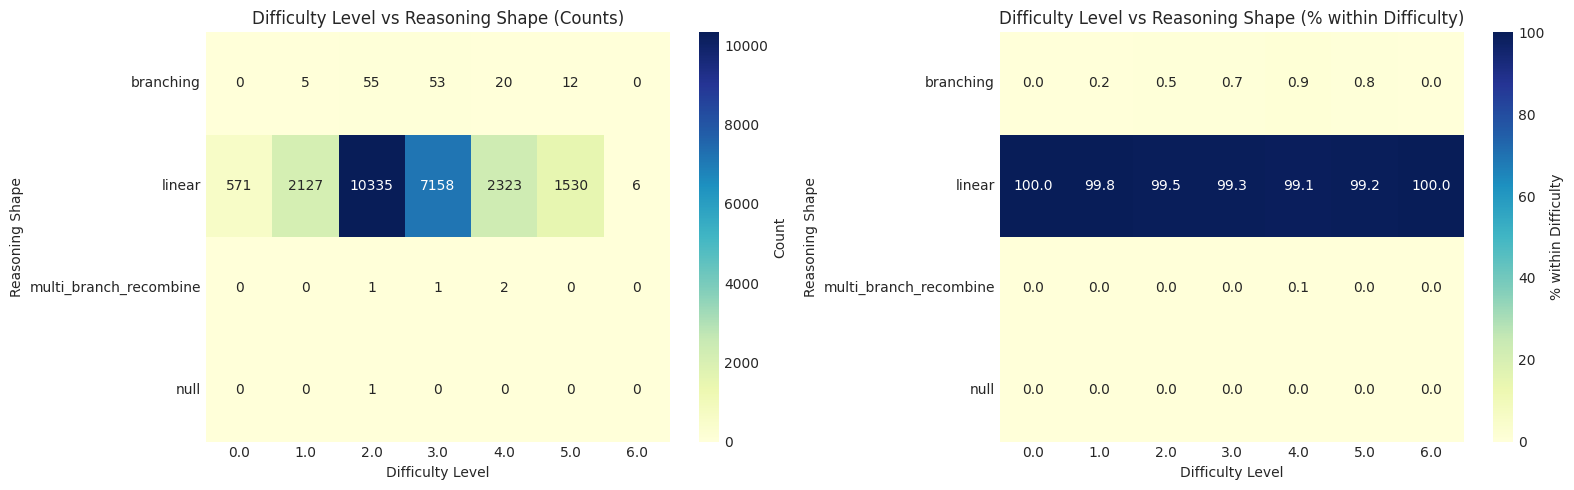

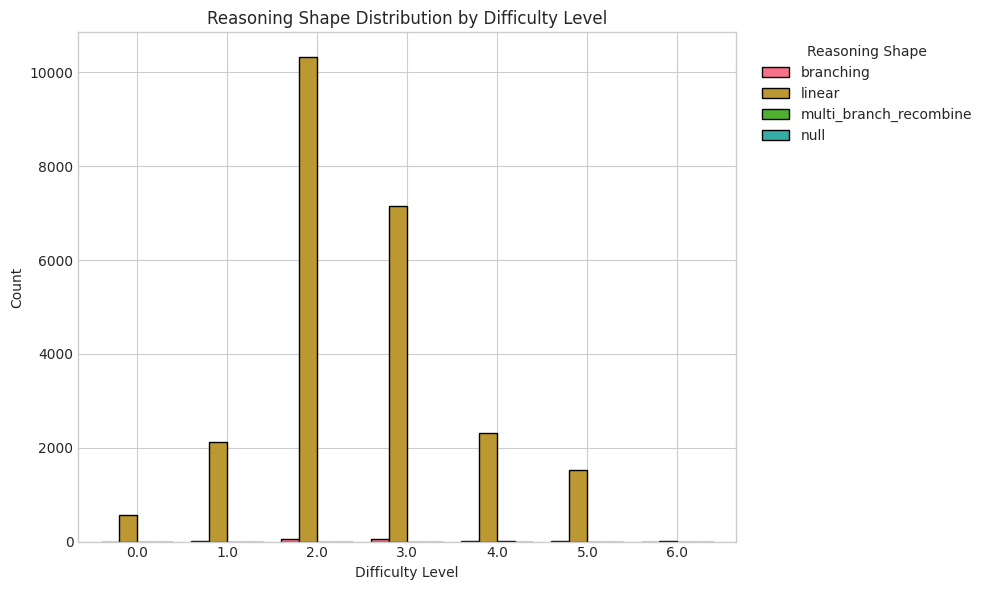

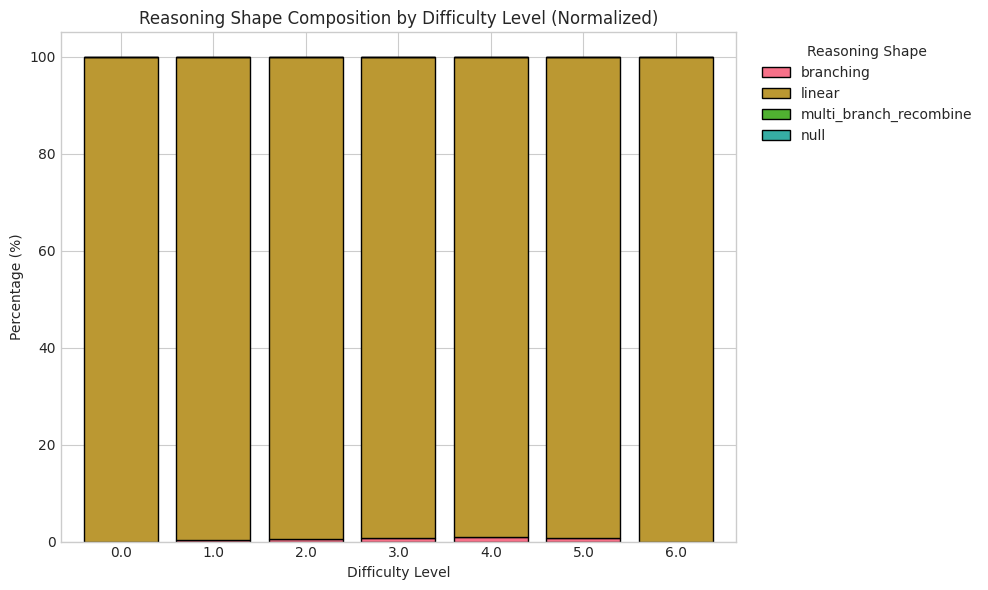

In [49]:
# Cross-tabulation: Difficulty Level vs Reasoning Shape
if 'difficulty_level' in df.columns and 'reasoning_shape' in df.columns:
    df_ds = df[df['difficulty_level'].notna() & df['reasoning_shape'].notna()].copy()
    print(f"Records with both difficulty and reasoning shape: {len(df_ds):,}")

    cross_tab_ds = pd.crosstab(df_ds['reasoning_shape'], df_ds['difficulty_level'])
    print("\nDifficulty Level vs Reasoning Shape (counts):")
    print(cross_tab_ds)

    # Normalized version (percentage within each difficulty level)
    cross_tab_ds_norm = pd.crosstab(df_ds['reasoning_shape'], df_ds['difficulty_level'], normalize='columns') * 100
    print("\nDifficulty Level vs Reasoning Shape (% within difficulty level):")
    print(cross_tab_ds_norm.round(1))

    # --- Plot 1: Heatmap (counts) ---
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))

    sns.heatmap(cross_tab_ds, annot=True, fmt='d', cmap='YlGnBu', ax=axes[0],
                cbar_kws={'label': 'Count'})
    axes[0].set_title('Difficulty Level vs Reasoning Shape (Counts)')
    axes[0].set_xlabel('Difficulty Level')
    axes[0].set_ylabel('Reasoning Shape')

    sns.heatmap(cross_tab_ds_norm, annot=True, fmt='.1f', cmap='YlGnBu', ax=axes[1],
                cbar_kws={'label': '% within Difficulty'})
    axes[1].set_title('Difficulty Level vs Reasoning Shape (% within Difficulty)')
    axes[1].set_xlabel('Difficulty Level')
    axes[1].set_ylabel('Reasoning Shape')

    plt.tight_layout()
    plt.show()

    # --- Plot 2: Grouped bar chart ---
    cross_tab_ds_plot = cross_tab_ds.T  # transpose so difficulty is on x-axis
    fig, ax = plt.subplots(figsize=(10, 6))
    cross_tab_ds_plot.plot(kind='bar', ax=ax, edgecolor='black', width=0.8)
    ax.set_xlabel('Difficulty Level')
    ax.set_ylabel('Count')
    ax.set_title('Reasoning Shape Distribution by Difficulty Level')
    ax.legend(title='Reasoning Shape', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # --- Plot 3: 100% stacked bar (composition within each difficulty) ---
    cross_tab_ds_pct = cross_tab_ds_norm.T  # transpose so difficulty is on x-axis
    fig, ax = plt.subplots(figsize=(10, 6))
    cross_tab_ds_pct.plot(kind='bar', stacked=True, ax=ax, edgecolor='black', width=0.8)
    ax.set_xlabel('Difficulty Level')
    ax.set_ylabel('Percentage (%)')
    ax.set_title('Reasoning Shape Composition by Difficulty Level (Normalized)')
    ax.legend(title='Reasoning Shape', bbox_to_anchor=(1.02, 1), loc='upper left')
    ax.set_ylim(0, 105)
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()
else:
    print("Difficulty level or reasoning shape data not available")

## Effective Difficulty vs Computation Bucket Level

The **computation bucket level** (`difficulty_level`) is the raw minimum level where `passes >= 1` (values 0, 1, 2).

The **effective difficulty score** combines bucket level with text structure (mechanisms, constraints, objects) and solution structure (reasoning depth, case split, reasoning shape, technique transitions, invariant, scope, pruning, reuse) into a continuous score, then maps it to quintile levels 1-5.

This section computes effective difficulty inline (same formula as pipeline step 6) and compares the two measures.

In [50]:
# Compute mixed difficulty score (same formula as pipeline step 6)
def _safe_int(val, default=0):
    """Convert to int, treating NaN/None/non-numeric strings as default."""
    if val is None or (isinstance(val, float) and np.isnan(val)):
        return default
    if isinstance(val, str) and val.strip().lower() in ('null', 'none', ''):
        return default
    try:
        return int(val)
    except (TypeError, ValueError):
        return default

def mixed_difficulty(B, row):
    """D = bucket_level + delta_text + delta_solution, clipped to [0, 6]."""
    if B is None or (isinstance(B, float) and np.isnan(B)) or (isinstance(B, str) and B.strip().lower() in ('null', 'none', '')):
        B = 2
    else:
        B = _safe_int(B, default=2)
    m = _safe_int(row.get('mechanisms_count'))
    c = _safe_int(row.get('constraints_count'))
    o = _safe_int(row.get('objects_count'))
    delta_text = 0.30 * m + 0.10 * max(0, c - 1) + 0.05 * max(0, o - 1)

    w_d  = {'shallow': -0.15, 'medium': 0.0, 'deep': 0.30}.get(row.get('reasoning_depth'), 0.0)
    w_cs = {'none': 0.0, 'binary': 0.15, 'multi': 0.30}.get(row.get('case_split'), 0.0)
    w_rs = {'linear': 0.0, 'branching': 0.20}.get(row.get('reasoning_shape'), 0.0)
    w_t  = 0.10 * min(_safe_int(row.get('technique_transitions')), 3)
    w_inv = {'none': 0.0, 'implicit': 0.15, 'explicit': 0.30}.get(row.get('invariant'), 0.0)
    w_sc = {'local': 0.0, 'global': 0.15}.get(row.get('reasoning_scope'), 0.0)
    w_pr = 0.10 if row.get('dead_end_pruning') is True else 0.0
    w_re = {'single': 0.0, 'multiple': 0.10}.get(row.get('intermediate_reuse'), 0.0)
    delta_sol = w_d + w_cs + w_rs + w_t + w_inv + w_sc + w_pr + w_re

    return np.clip(B + delta_text + delta_sol, 0, 6)

# Compute raw score for every row
df['mixed_difficulty_raw'] = df.apply(lambda r: mixed_difficulty(r.get('difficulty_level'), r), axis=1)

# Build quintile mapper (1-5) from the score distribution
quantiles = np.quantile(df['mixed_difficulty_raw'].dropna(), [0.2, 0.4, 0.6, 0.8])

def map_to_quintile(d):
    if pd.isna(d):
        return np.nan
    if d <= quantiles[0]: return 1
    if d <= quantiles[1]: return 2
    if d <= quantiles[2]: return 3
    if d <= quantiles[3]: return 4
    return 5

df['effective_difficulty'] = df['mixed_difficulty_raw'].apply(map_to_quintile).astype('Int64')

print(f"Quantile thresholds: {quantiles}")
print(f"\nRaw mixed_difficulty stats:")
print(df['mixed_difficulty_raw'].describe().round(3))
print(f"\nEffective difficulty (1-5) distribution:")
print(df['effective_difficulty'].value_counts().sort_index())

Quantile thresholds: [2.05 2.2  2.4  2.8 ]

Raw mixed_difficulty stats:
count    71832.000
mean         2.438
std          0.710
min          0.000
25%          2.100
50%          2.300
75%          2.600
max          6.000
Name: mixed_difficulty_raw, dtype: float64

Effective difficulty (1-5) distribution:
effective_difficulty
1    15820
2    15408
3    13964
4    12964
5    13676
Name: count, dtype: Int64


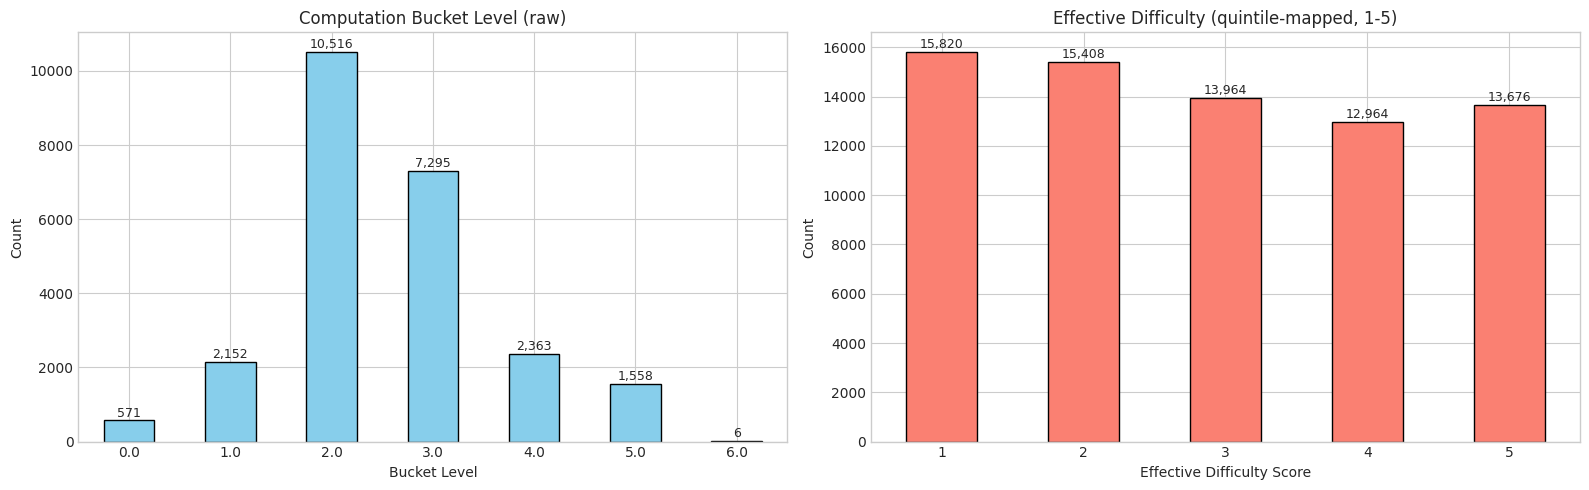

Bucket Level vs Effective Difficulty (counts):
Effective Difficulty     1     2     3     4     5
Bucket Level                                      
0.0                    571     0     0     0     0
1.0                   2152     0     0     0     0
2.0                   4663  2812  1714  1209   118
3.0                      0     0     0     0  7295
4.0                      0     0     0     0  2363
5.0                      0     0     0     0  1558
6.0                      0     0     0     0     6


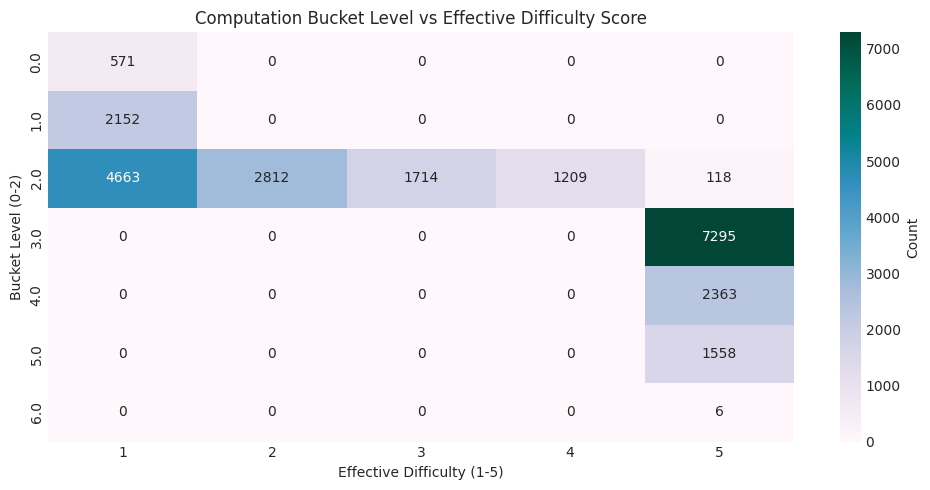

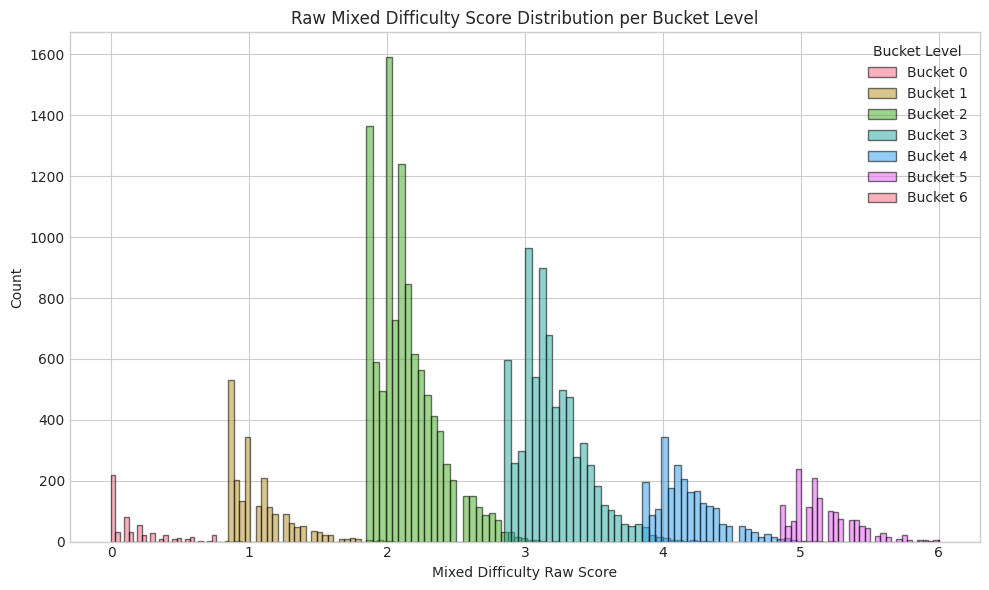

/tmp/ipykernel_3942/4194257720.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_plot, x='bucket_label', y='mixed_difficulty_raw', ax=ax,


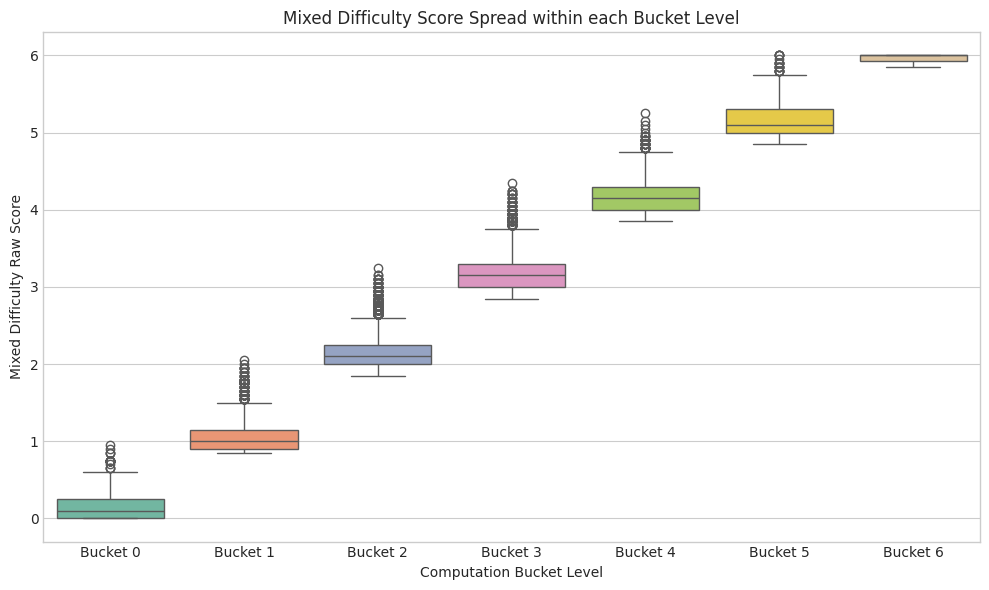


Correlation matrix:
                      difficulty_level  mixed_difficulty_raw  \
difficulty_level                 1.000                 0.978   
mixed_difficulty_raw             0.978                 1.000   
effective_difficulty             0.787                 0.788   

                      effective_difficulty  
difficulty_level                     0.787  
mixed_difficulty_raw                 0.788  
effective_difficulty                 1.000  


In [51]:
# --- Compare: side-by-side distributions ---
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Left: raw bucket level (0, 1, 2)
bucket_counts = df['difficulty_level'].value_counts().sort_index()
bucket_counts.plot(kind='bar', ax=axes[0], color='skyblue', edgecolor='black')
axes[0].set_xlabel('Bucket Level')
axes[0].set_ylabel('Count')
axes[0].set_title('Computation Bucket Level (raw)')
for i, v in enumerate(bucket_counts.values):
    axes[0].text(i, v + max(bucket_counts.values)*0.01, f'{v:,}', ha='center', fontsize=9)
axes[0].tick_params(axis='x', rotation=0)

# Right: effective difficulty (1-5)
eff_counts = df['effective_difficulty'].value_counts().sort_index()
eff_counts.plot(kind='bar', ax=axes[1], color='salmon', edgecolor='black')
axes[1].set_xlabel('Effective Difficulty Score')
axes[1].set_ylabel('Count')
axes[1].set_title('Effective Difficulty (quintile-mapped, 1-5)')
for i, v in enumerate(eff_counts.values):
    axes[1].text(i, v + max(eff_counts.values)*0.01, f'{v:,}', ha='center', fontsize=9)
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

# --- Cross-tabulation: bucket level vs effective difficulty ---
cross_be = pd.crosstab(df['difficulty_level'], df['effective_difficulty'])
cross_be.index.name = 'Bucket Level'
cross_be.columns.name = 'Effective Difficulty'
print("Bucket Level vs Effective Difficulty (counts):")
print(cross_be)

fig, ax = plt.subplots(figsize=(10, 5))
sns.heatmap(cross_be, annot=True, fmt='d', cmap='PuBuGn', ax=ax, cbar_kws={'label': 'Count'})
ax.set_title('Computation Bucket Level vs Effective Difficulty Score')
ax.set_xlabel('Effective Difficulty (1-5)')
ax.set_ylabel('Bucket Level (0-2)')
plt.tight_layout()
plt.show()

# --- Raw score distribution per bucket level (shows the spread the mixed score adds) ---
fig, ax = plt.subplots(figsize=(10, 6))
for bl in sorted(df['difficulty_level'].dropna().unique()):
    subset = df[df['difficulty_level'] == bl]['mixed_difficulty_raw']
    ax.hist(subset, bins=30, alpha=0.55, label=f'Bucket {int(bl)}', edgecolor='black')
ax.set_xlabel('Mixed Difficulty Raw Score')
ax.set_ylabel('Count')
ax.set_title('Raw Mixed Difficulty Score Distribution per Bucket Level')
ax.legend(title='Bucket Level')
plt.tight_layout()
plt.show()

# --- Box plot: effective difficulty by bucket level ---
fig, ax = plt.subplots(figsize=(10, 6))
df_plot = df[df['difficulty_level'].notna() & df['effective_difficulty'].notna()].copy()
df_plot['bucket_label'] = 'Bucket ' + df_plot['difficulty_level'].astype(int).astype(str)
sns.boxplot(data=df_plot, x='bucket_label', y='mixed_difficulty_raw', ax=ax,
            order=[f'Bucket {i}' for i in sorted(df_plot['difficulty_level'].unique().astype(int))],
            palette='Set2')
ax.set_xlabel('Computation Bucket Level')
ax.set_ylabel('Mixed Difficulty Raw Score')
ax.set_title('Mixed Difficulty Score Spread within each Bucket Level')
plt.tight_layout()
plt.show()

# --- Correlation ---
corr = df[['difficulty_level', 'mixed_difficulty_raw', 'effective_difficulty']].corr()
print("\nCorrelation matrix:")
print(corr.round(3))

## Summary Statistics

In [52]:
print("=" * 100)
print("SUMMARY STATISTICS")
print("=" * 100)

print(f"\nTotal Records: {len(df):,}")
if 'domain' in df.columns:
    print(f"Records with Domain: {df['domain'].notna().sum():,} ({df['domain'].notna().sum()/len(df)*100:.1f}%)")
if 'difficulty_level' in df.columns:
    print(f"Records with Difficulty Level: {df['difficulty_level'].notna().sum():,} ({df['difficulty_level'].notna().sum()/len(df)*100:.1f}%)")

if 'domain' in df.columns and df['domain'].notna().any():
    print("\nTop Domains:")
    top_domains = df['domain'].value_counts().head(10)
    for domain, count in top_domains.items():
        print(f"  {domain}: {count:,} ({count/len(df)*100:.1f}%)")

if 'difficulty_level' in df.columns and df['difficulty_level'].notna().any():
    print("\nDifficulty Level Summary:")
    print("  (Extracted from computation_buckets: minimum level where passes == 1)")
    for level, count in df['difficulty_level'].value_counts().sort_index().items():
        print(f"  Level {level}: {count:,} ({count/df['difficulty_level'].notna().sum()*100:.1f}%)")
    
    print(f"\nAverage Difficulty Level: {df['difficulty_level'].mean():.2f}")
    print(f"Median Difficulty Level: {df['difficulty_level'].median():.1f}")
    
    records_without_diff = df['difficulty_level'].isna().sum()
    if records_without_diff > 0:
        print(f"\nNote: {records_without_diff:,} records ({records_without_diff/len(df)*100:.1f}%) have no difficulty level")
        print("      (no computation_buckets with passes == 1)")

if 'reasoning_depth' in df.columns and df['reasoning_depth'].notna().any():
    print("\nReasoning Depth Summary:")
    for depth, count in df['reasoning_depth'].value_counts().items():
        print(f"  {depth}: {count:,} ({count/df['reasoning_depth'].notna().sum()*100:.1f}%)")

SUMMARY STATISTICS

Total Records: 71,832
Records with Domain: 71,724 (99.8%)
Records with Difficulty Level: 24,461 (34.1%)

Top Domains:
  number_theory: 20,567 (28.6%)
  algebra: 19,174 (26.7%)
  geometry: 16,898 (23.5%)
  combinatorics: 13,591 (18.9%)
  mixed: 1,494 (2.1%)

Difficulty Level Summary:
  (Extracted from computation_buckets: minimum level where passes == 1)
  Level 0.0: 571 (2.3%)
  Level 1.0: 2,152 (8.8%)
  Level 2.0: 10,516 (43.0%)
  Level 3.0: 7,295 (29.8%)
  Level 4.0: 2,363 (9.7%)
  Level 5.0: 1,558 (6.4%)
  Level 6.0: 6 (0.0%)

Average Difficulty Level: 2.55
Median Difficulty Level: 2.0

Note: 47,371 records (65.9%) have no difficulty level
      (no computation_buckets with passes == 1)

Reasoning Depth Summary:
  medium: 46,182 (64.7%)
  shallow: 14,430 (20.2%)
  deep: 10,806 (15.1%)
  null: 2 (0.0%)
